In [152]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [153]:
from model.eGauss_plus import eGAUSSp

In [154]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [155]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset


device = torch.device("cpu")

num_clients = 4

#data = balance_dataset(data)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 


In [156]:

# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 5,
    "kappa_join": 3,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 3,
    "kappa_join": 2,
    "S_0": 1e-8,
    "c_max": 2,
    "device": torch.device("cpu")
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


Client 1: {0: 49751, 1: 90}
Client 2: {0: 37325, 1: 55}
Client 3: {0: 27978, 1: 57}
Client 4: {0: 20997, 1: 30}
Test Set: {0: 85289, 1: 154}

Combined Number of Samples per Class:
Class 0: 221340 samples
Class 1: 386 samples

Total Number of Samples Across All Datasets: 221726


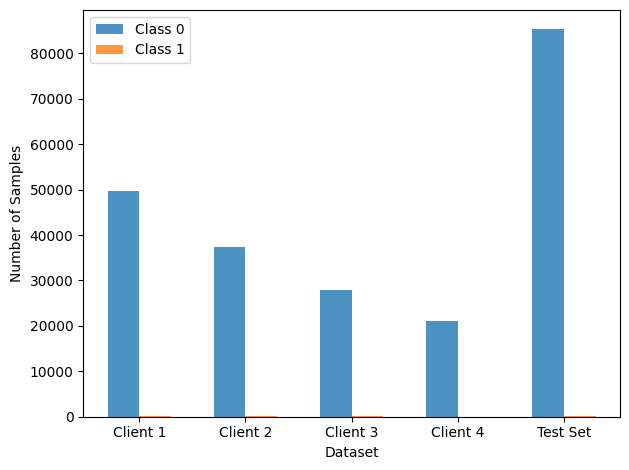

In [157]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
plot_dataset_split(client_train, test_data)

In [158]:
import utils.utils_train
from utils.utils_train import train_supervised, train_unsupervised
from utils.utils_plots import plot_first_feature

if False:

    # Assuming models and client_data are already defined
    for client_idx, client_model in enumerate(local_models):
        print(f"Training model for client {client_idx + 1}")
        train_supervised(client_model, client_train[client_idx]) 
        plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  


In [159]:
import utils.utils_train
from utils.utils_train import train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train)


Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Processed 1000 points.Number of clusters: 911
Processed 1000 points.Number of clusters: 892
Processed 1000 points.Number of clusters: 903
Processed 1000 points.Number of clusters: 870
Processed 2000 points.Number of clusters: 1689
Processed 2000 points.Number of clusters: 1684
Processed 2000 points.Number of clusters: 1642
Processed 2000 points.Number of clusters: 1642
Processed 3000 points.Number of clusters: 2363
Processed 3000 points.Number of clusters: 2370
Processed 3000 points.Number of clusters: 2324
Processed 3000 points.Number of clusters: 2299
Processed 4000 points.Number of clusters: 3007
Processed 4000 points.Number of clusters: 3055
Processed 4000 points.Number of clusters: 2947
Processed 4000 points.Number of clusters: 2992
Processed 5000 points.Number of clusters: 3593
Processed 5000 points.Number of clusters: 3559
Processed 5000 points.Number of clusters: 3715
Pro

In [160]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
for client_idx, client_model in enumerate(local_models):
    print(f"\nTesting model for client {client_idx + 1}")
    test_model(client_model, test_data)
    test_model(client_model, all_data)



Testing model for client 1
Evolving has been disabled.


KeyboardInterrupt: 

In [ ]:

for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        client_model.federal_agent.federated_merging() 
        print(f" Number of client {client_idx + 1} clusters = {torch.sum(client_model.n[:client_model.c]>1)}")
        federated_model.federal_agent.merge_model_privately(client_model, 1)

print(f"Number of clusters after transfer = {federated_model.c}")

Merging client 1
 Number of client 1 clusters = 8
Merging client 2
 Number of client 2 clusters = 3
Merging client 3
 Number of client 3 clusters = 14
Merging client 4
 Number of client 4 clusters = 3
Number of clusters after transfer = 28


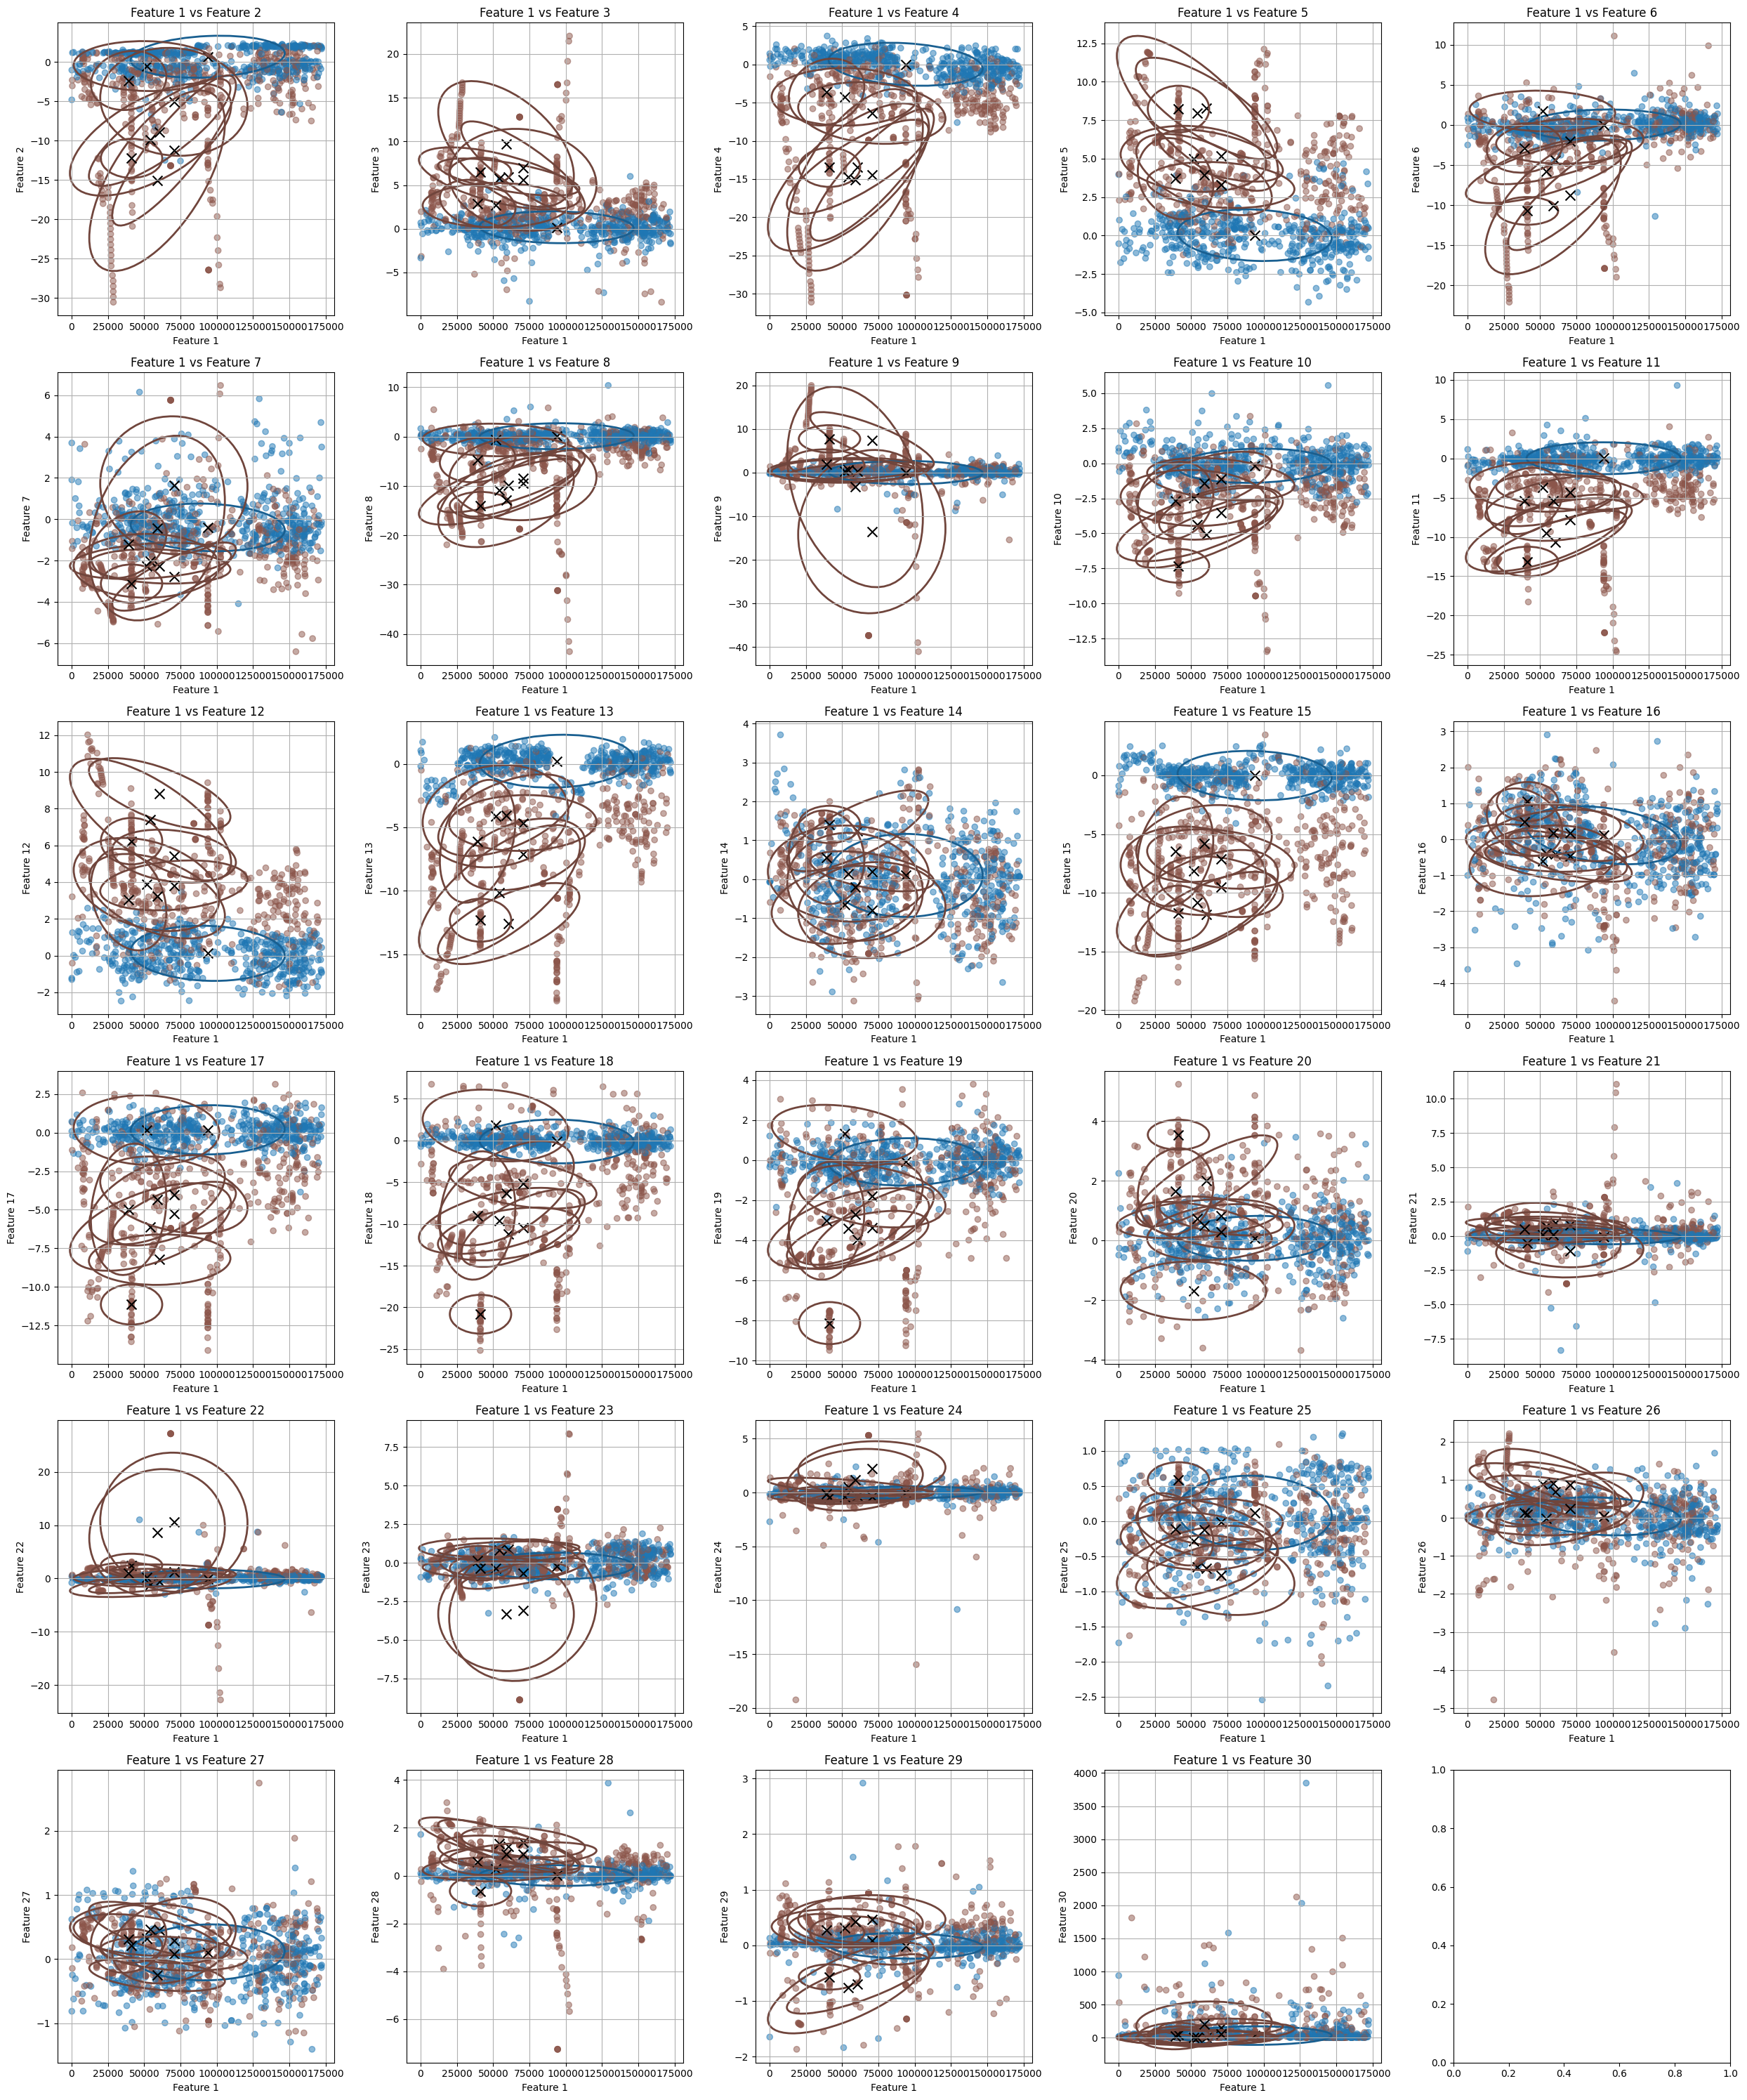


Testing federated model
Evolving has been disabled.
Test Accuracy: 0.8682432432432432, Precision: 0.8912888094706277, Recall: 0.8682432432432432, F1 Score: 0.8672390802354701
Evolving has been disabled.
Test Accuracy: 0.8689024390243902, Precision: 0.885811496835238, Recall: 0.8689024390243902, F1 Score: 0.867450114708238


In [ ]:
from utils.utils_train import test_model

federated_model.federal_agent.federated_merging()
print(f"Number of clusters after merging = {federated_model.c}")

plot_first_feature(all_data, model=federated_model, num_sigma=2, N_max=1)   

print(f"\nTesting federated model")   

test_model(federated_model, test_data)
test_model(federated_model, all_data)